In [149]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import ShuffleSplit,GridSearchCV,train_test_split,cross_val_score
from sklearn.neighbors import KNeighborsClassifier
# from imblearn.over_sampling import SMOTE
# from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import metrics

### EDA

In [150]:
data = pd.read_csv('DS_dim_users_new.csv', low_memory=False)

In [151]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 556880 entries, 0 to 556879
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   device_id            556880 non-null  object 
 1   wizard_teams         330004 non-null  float64
 2   wizard_leagues       330059 non-null  float64
 3   install_time         556880 non-null  object 
 4   last_touch           556880 non-null  object 
 5   lang_id              556771 non-null  float64
 6   country_id           556822 non-null  float64
 7   media_source         43564 non-null   object 
 8   device_type          556880 non-null  object 
 9   os_version           556497 non-null  object 
 10  media_source1        43564 non-null   object 
 11  campaign_name        29137 non-null   object 
 12  is_finished_wizard   556871 non-null  object 
 13  device_model         551299 non-null  object 
 14  is_google_connect    556880 non-null  bool   
 15  is_facebook_conne

- ```From the first observation, I presume that the dataset contains several numerical, categorical, boolean and datetime columns providing various information about the user```

In [152]:
data_additional = pd.read_csv('DS_dim_user_selections_new.csv')

In [328]:
cols_for_pie = ['platform', 'user_country', 'user_language', 'entity_name',
       'entity_country', 'entity_type', 'sport_type', 'region_name',
       'app_version', 'idx']

# 'platform', 'user_country', 'user_language', 'favorite', 'region_name', 'entity_id', 'app_version', 'idx'

data_additional[cols_for_pie] = data_additional[cols_for_pie].astype('category')

data_additional['updatedate'] = pd.to_datetime(data_additional['updatedate'], format='%Y-%m-%d %H:%M:%S.%f')
               
data_additional['last_touch'] = data_additional['last_touch'].\
            apply(lambda x: pd.to_datetime(x, errors = 'coerce', format = '%Y-%m-%d'))

In [329]:
data_additional.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913874 entries, 0 to 913873
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   uid             913874 non-null  int64         
 1   device_id       913874 non-null  object        
 2   platform        913874 non-null  category      
 3   user_country    903313 non-null  category      
 4   user_language   912969 non-null  category      
 5   entity_name     871663 non-null  category      
 6   entity_country  871363 non-null  category      
 7   entity_type     876513 non-null  category      
 8   sport_type      859858 non-null  category      
 9   local_entity    913874 non-null  int64         
 10  favorite        913874 non-null  int64         
 11  region_name     903313 non-null  category      
 12  entity_id       913874 non-null  int64         
 13  app_version     913852 non-null  category      
 14  last_touch      913874 non-null  dat

- ```From the first observation, I presume that the dataset contains several numerical, categorical and datetime columns providing various information about the user```

- ``` entity_name, entity_country, entity_type, local_entity, sport_type \ - these variables characterize the user target interest and it is codded as entity_id```

In [155]:
check = pd.DataFrame()
check['entity_code'] = pd.Series(data_additional['entity_country'].astype(str).values + '_' + \
        data_additional['entity_type'].astype(str).values + '_' +  data_additional['entity_name'].\
        astype(str).values + '_' + data_additional['local_entity'].\
              astype(str).values + '_' + data_additional['sport_type'].astype(str).values).\
                astype('category').cat.codes

check['entity'] = pd.Series(data_additional['entity_country'].astype(str).values + '_' + \
        data_additional['entity_type'].astype(str).values + '_' +  data_additional['entity_name'].\
        astype(str).values + '_' + data_additional['local_entity'].\
              astype(str).values + '_' + data_additional['sport_type'].astype(str).values)
check['entity_id'] = data_additional['entity_id'].values

In [156]:
check['entity_code'].value_counts(),check['entity_id'].value_counts()

(11710    55834
 15369    47684
 25319    37361
 10240    35162
 10917    26818
          ...  
 2351         1
 979          1
 12099        1
 24974        1
 1634         1
 Name: entity_code, Length: 25322, dtype: int64,
 25         55839
 17         47684
 1          35866
 573        35164
 35         26834
            ...  
 3644125        1
 62353          1
 45670          1
 61721          1
 3515473        1
 Name: entity_id, Length: 27122, dtype: int64)

In [157]:
check[check['entity_code'] == 11710].describe()

,entity_code,entity_id
count,55834.0,55834.0
mean,11710.0,25.0
std,0.0,0.0
min,11710.0,25.0
25%,11710.0,25.0
50%,11710.0,25.0
75%,11710.0,25.0
max,11710.0,25.0


In [158]:
check[check['entity_code'] == 11710].head(2)

,entity_code,entity,entity_id
15,11710,Germany_league_Bundesliga_0_Soccer,25
64,11710,Germany_league_Bundesliga_0_Soccer,25


### The hypothesis is true and further as feature we can use entity id as the general characteristic for entity 

- `In data description said that unique identifier for each user is the device_ID`
- `Let's check that uid and device_id holds the same info`

In [159]:
data_additional.groupby(['uid'])['device_id'].apply(lambda x: len(x.unique())).value_counts()


1     303006
2        866
3         32
4         18
5          8
6          6
7          4
9          3
8          2
10         2
19         2
40         1
12         1
13         1
32         1
11         1
27         1
29         1
84         1
Name: device_id, dtype: int64

In [160]:
data_additional.groupby(['device_id'])['uid'].apply(lambda x: len(x.unique())).value_counts()

1    305359
Name: uid, dtype: int64

- `So, for some uid identifier we have more then one device_id, and the uid is unique for every device_id, I can assume that it is the identifier of users who use several devices from one account`

## Let's find useless columns, further this columns should'n be used in solution prototyping 

In [161]:
for source in [data, data_additional]:
    for i in source.columns:
        if len(source[i].unique()) == 1:
            print(f'{i} column contains {source[i].isna().sum(axis = 0)/source[i].size * 100 } % of null values')

campaign_related column contains 100.0 % of null values


In [162]:
data.describe()

,wizard_teams,wizard_leagues,lang_id,country_id,campaign_related
count,330004.000000,330059.000000,5.567710e+05,5.568220e+05,0.0
mean,12.383535,9.745236,3.874411e+03,7.772749e+03,NaN
std,35.317273,13.480513,2.878005e+06,4.069924e+06,NaN
min,-1.000000,-1.000000,-1.000000e+00,-1.000000e+00,NaN
25%,0.000000,0.000000,-1.000000e+00,2.100000e+01,NaN
50%,3.000000,5.000000,2.700000e+01,2.100000e+01,NaN
75%,12.000000,14.000000,2.700000e+01,1.220000e+02,NaN
max,2534.000000,684.000000,2.147484e+09,2.147484e+09,NaN


## Check for null values

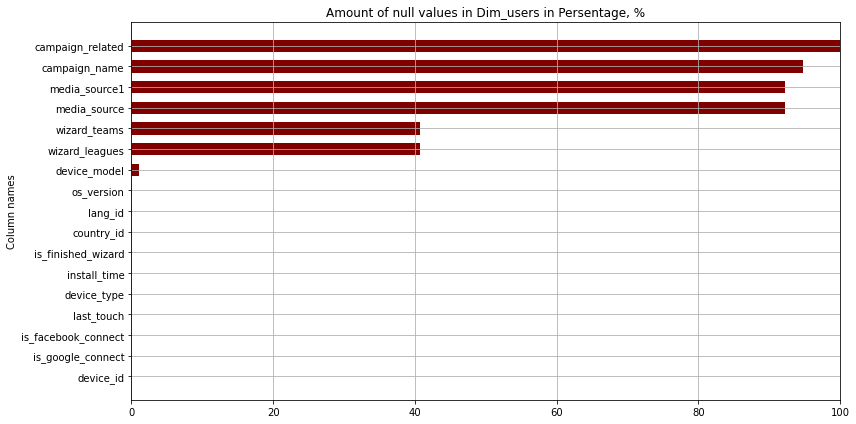

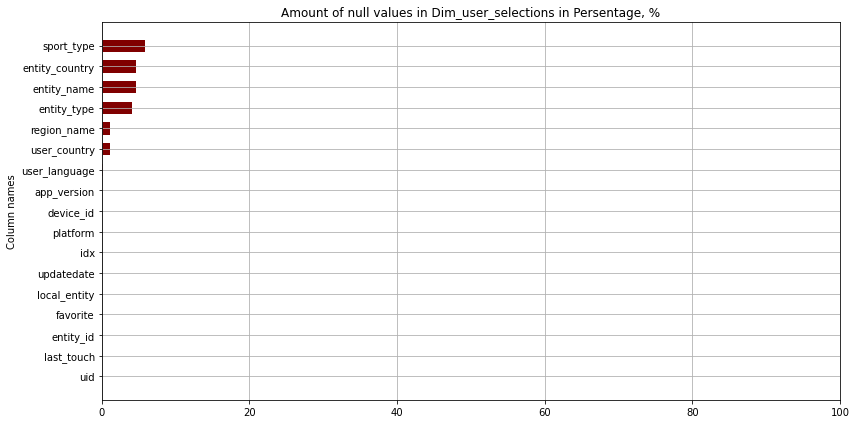

In [163]:
for source, var_name in zip([data, data_additional], ["Dim_users", "Dim_user_selections"]):
    vals = (source.isnull().sum() / source.shape[0] * 100).sort_values()
    fig, ax = plt.subplots(figsize = (12, 6))
    ax.barh(vals.index, vals.values, height = 0.6,
    color ='maroon')
    
    ax.set_title(f"Amount of null values in {var_name} in Persentage, %")
    ax.set_ylabel("Column names")
    ax.grid()
    ax.set_xlim(0, 100)

    fig.tight_layout()

- `As it was said in previouse paragraph, compaign related feature - is useless`
- `media_source, media_source1 can be a good feature for churn prdiction, let's try to analyze whether we can fill the gap and check whether they differ`

In [164]:
data[['media_source', 'media_source1']].describe()

,media_source,media_source1
count,43564,43564
unique,25,25
top,Google Ads ACI,Google Ads ACI
freq,21829,21829


In [168]:
col_difference = pd.Series(np.where((df['media_source'] == df['media_source1']), 'Yes', 'No'))

In [169]:
col_difference.value_counts()

Yes    556880
dtype: int64

In [350]:
data[['wizard_teams', 'wizard_leagues']].describe()

,wizard_teams,wizard_leagues
count,330004.000000,330059.000000
mean,12.383535,9.745236
std,35.317273,13.480513
min,-1.000000,-1.000000
25%,0.000000,0.000000
50%,3.000000,5.000000
75%,12.000000,14.000000
max,2534.000000,684.000000


In [357]:
#This features are higly correlated 
data[['wizard_teams', 'wizard_leagues']].corr(method = 'spearman'), data[['wizard_teams', \
                                            'wizard_leagues']].corr()

(                wizard_teams  wizard_leagues
 wizard_teams        1.000000        0.827817
 wizard_leagues      0.827817        1.000000,
                 wizard_teams  wizard_leagues
 wizard_teams        1.000000        0.435081
 wizard_leagues      0.435081        1.000000)

In [354]:
pd.Series(np.where((df['wizard_teams'] != df['wizard_leagues']), 'No', 'Yes')).value_counts()

Yes    347354
No     209526
dtype: int64

- `wizard_teams and wizard_leagues are higly correlated and depended, probably only one feature should be used in base model bc our feature matix will have zero determinant and it's not good for linear models`

### So, we should drop media_source1, compaign_related from data

In [171]:
data.drop(columns=['media_source1', 'campaign_related'], inplace = True)

## Let's check how staitforward are all charectiristics

In [330]:
for feature in cols_for_pie:
    print(f"Cardinality of {feature}:" , len(data_additional.groupby(feature).size()))

Cardinality of platform: 2
Cardinality of user_country: 196
Cardinality of user_language: 45
Cardinality of entity_name: 24948
Cardinality of entity_country: 211
Cardinality of entity_type: 4
Cardinality of sport_type: 15
Cardinality of region_name: 7
Cardinality of app_version: 471
Cardinality of idx: 3


In [179]:
data

,device_id,wizard_teams,wizard_leagues,install_time,last_touch,lang_id,country_id,media_source,device_type,os_version,campaign_name,is_finished_wizard,device_model,is_google_connect,is_facebook_connect
0,25BAC755-A01C-4F01-BDC9-93F208B056C8,10.0,1.0,2022-08-01 00:35:08.570193,2022-12-22 23:55:30.307947,27.0,122.0,NaN,ios,16.1.1,NaN,True,"iPhone12,1",False,False
1,D872EB9C-9D7C-4BB5-9F93-DAE205DBC77C,1.0,4.0,2022-08-01 01:06:34.698656,2022-12-27 20:23:06.924687,1.0,114.0,NaN,ios,16.1.1,NaN,True,"iPhone11,6",False,True
2,A97BB287-038F-473D-ADB2-B14523FA186A,52.0,20.0,2022-08-01 01:21:34.164914,2022-12-26 15:43:04.212841,27.0,122.0,NaN,ios,16.2,NaN,True,"iPhone10,6",False,True
3,3BA8010D-D327-4829-A40C-AE06941A75B8,0.0,0.0,2022-08-01 02:14:59.689760,2022-12-25 19:39:32.245611,27.0,131.0,NaN,ios,15.6,NaN,True,"iPhone10,6",False,True
4,059D978E-33F7-48C2-BFF1-9027FD869697,1.0,1.0,2022-08-01 03:37:00.888992,2022-12-23 23:22:51.776656,31.0,21.0,NaN,ios,16.1.1,NaN,True,"iPhone12,5",False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556875,f30bbef1-f84b-4840-adfc-f7a715236b36,NaN,NaN,2022-09-21 16:09:56.323000,2022-09-21 16:09:56.323000,-1.0,21.0,NaN,android,10,NaN,False,samsung sm-j610g,False,False
556876,8e67c975-4c48-4198-bbc3-de5c3f80cd14,NaN,NaN,2022-09-21 17:16:03.773000,2022-09-21 17:16:03.773000,27.0,131.0,NaN,android,7.0,NaN,False,huawei nxt-l29,False,False
556877,025bea2e-cdc1-4bd2-b0f6-8f359186c992,NaN,NaN,2022-09-21 18:19:35.487000,2022-09-21 18:19:35.487000,-1.0,0.0,NaN,android,11,NaN,False,samsung sm-a035m,False,False
556878,0f45f0db-70bb-4e8e-a0d5-cf8b40dd34d0,NaN,NaN,2022-11-17 14:24:28.647000,2022-11-17 14:24:28.647000,-1.0,0.0,NaN,android,12,NaN,False,samsung sm-a035m,False,False


## The data columns with amount of categories more than 15 has high cardinality, let's plot only data that has less classes

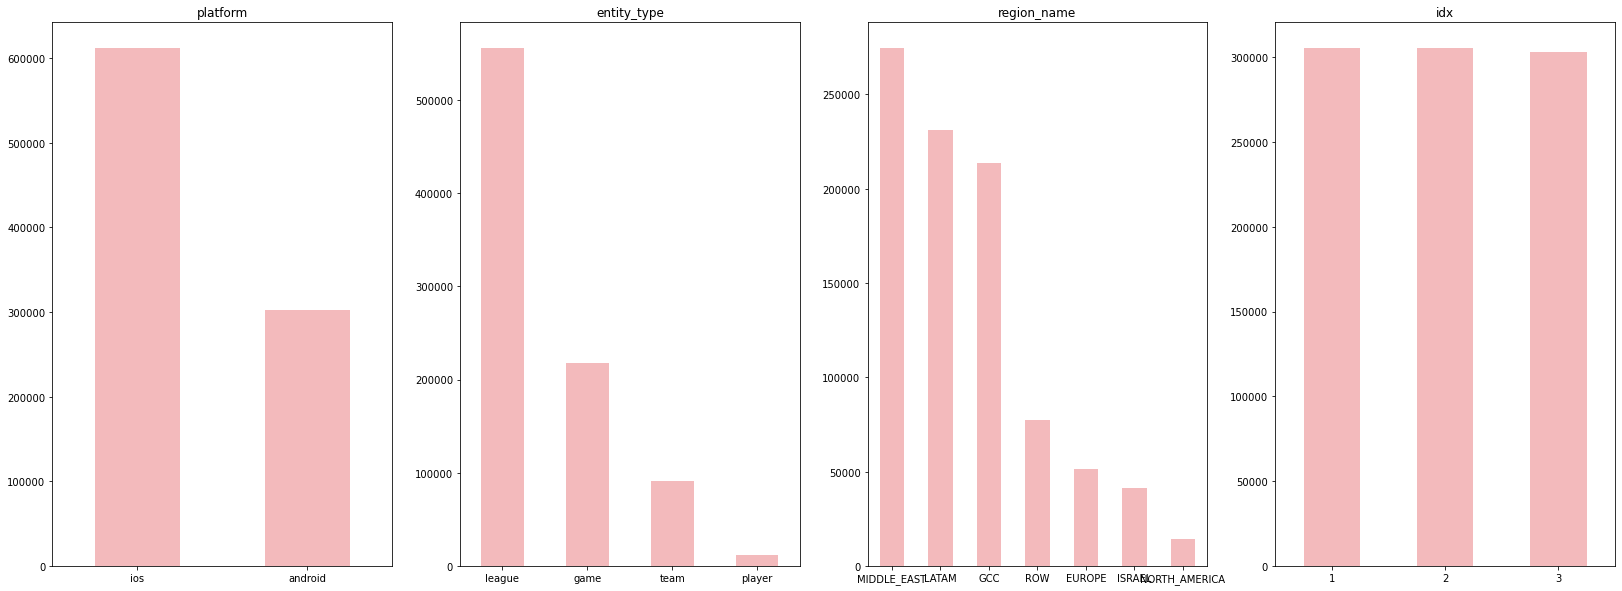

In [332]:
k = ['platform', 'entity_type', 'region_name', 'idx']
fig, axes = plt.subplots(nrows = 1, ncols = 4, figsize = (28,10))

for i, item in enumerate(k):
    
    ax = data_additional[item].value_counts().plot(
    kind = 'bar',ax=axes[i], rot = 0, color ='#f3babc' )
        
    ax.set_title(item)

- `We can observe that we have much more activity from user that use ios. And perform more actions 
on followong league and game`
- `The main activity is from Meadle East, Latin America and Gulf Cooperation Council (Saudi Arabia)`

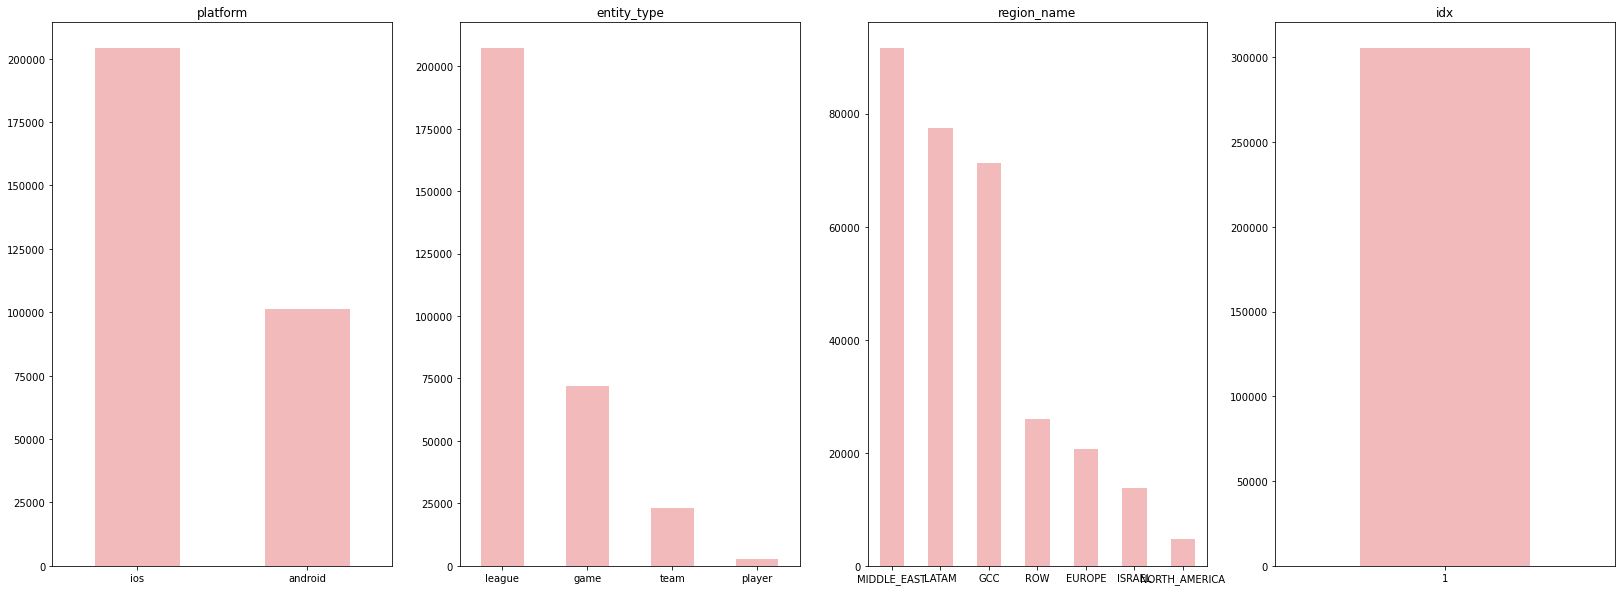

In [333]:
# Let's check this activities per user

k = ['platform', 'entity_type', 'region_name', 'idx']
fig, axes = plt.subplots(nrows = 1, ncols = 4, figsize = (28,10))

for i, item in enumerate(k):
    
    ax = data_additional.groupby('device_id')[item].agg(lambda x: x.value_counts().index[0]).value_counts().plot(
    kind = 'bar',ax=axes[i], rot = 0, color ='#f3babc' )
        
    ax.set_title(item)

- ` The the statistics per user is the same`
- ` The index idx states the time/code of the action and the 1 is the most popular for every user, so this deature is not usefull for churn prediction`
- ` Let's explore the App version feature, it has high cardianlity and differnet format of vesrion recorded`

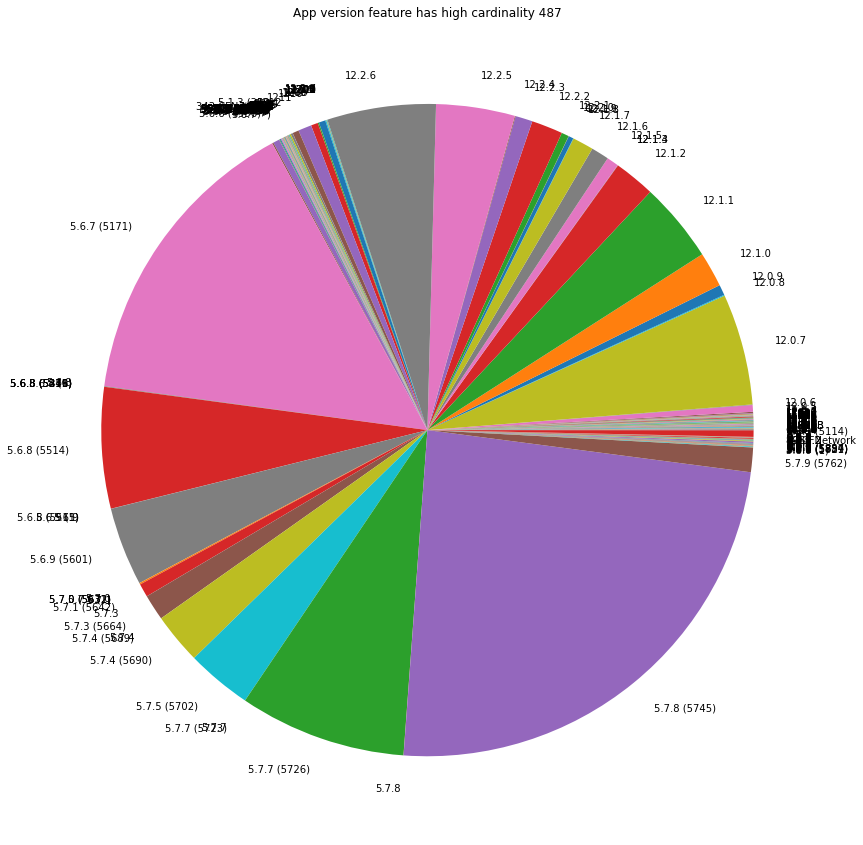

In [195]:
fig = plt.figure(figsize =(20, 15))
plt.pie(data_additional.groupby('app_version').size(), labels = data_additional.groupby('app_version').size().index)
plt.title('App version feature has high cardinality {}'.format(len(set(data_additional['app_version']))))
plt.show()

In [198]:
for platform in set(data_additional['platform']):
    print(data_additional.loc[data_additional['platform'] == platform, 'app_version'].value_counts())

5.7.8 (5745)    220240
5.6.7 (5171)    136590
5.7.7 (5726)     75613
5.6.8 (5514)     54799
5.6.9 (5601)     35523
                 ...  
12.1.5               0
12.1.4               0
12.1.3               0
12.1.2               0
962                  0
Name: app_version, Length: 486, dtype: int64
12.0.7           50320
12.2.6           49187
12.1.1           36282
12.2.5           35638
12.1.2           18618
                 ...  
5.7.5 (5702)         0
5.4.2 (1242)         0
5.7.7 (5723)         0
5.7.7 (5726)         0
343 CFNetwork        0
Name: app_version, Length: 486, dtype: int64


In [216]:
print(f"""Version names that are common for both platforms: \
{(set(data_additional.loc[data_additional['platform'] == 'ios', 'app_version'])) 
& (set(data_additional.loc[data_additional['platform'] == 'android', 'app_version']))}""")

Version names that are common for both platforms: {'5.6.7', '5.5.0', '5.6.4', '3.6.4'}


In [243]:
data_additional[['app_version_1', 'app_version_2']] = data_additional.app_version.str.split('\(|\)', \
                expand=True).iloc[: , [0, 1]]

In [304]:
app_v = dict(zip(data_additional['app_version_2'], data_additional['app_version_1']))
data_additional['app_version_3'] = data_additional['app_version_1'].apply(lambda x: app_v[x] if x in app_v.keys() else x)

In [313]:
print('Cross mapping vesrion name gives {} unique namings'.\
      format(len(set(data_additional['app_version']))))

Cross mapping vesrion name gives 487 unique namings


In [312]:
print('Cross mapping vesrion name gives {} unique namings'.\
      format(len(set(data_additional['app_version_3']))))

Cross mapping vesrion name gives 472 unique namings


In [311]:
print('Taking vesrion name gives {} unique namings'.\
      format(len(set(data_additional['app_version'].apply(lambda x: x.split('.')[0])))))


Taking vesrion name gives 84 unique namings


In [315]:
data_additional['app_version'] = data_additional['app_version_3'].values

In [316]:
data_additional.drop(columns = ['app_version_3', 'app_version_2', 'app_version_1'], inplace = True)

- `It can be reduced to 84, but we should consider the logic beyong this version assigning. So I performed only replacing by alredy existing codes when the naming is long`

## Let's aggregate features that can be useful for churn prediction for every user

- I selected the following:  'platform', 'user_country', 'user_language', 'favorite', 'region_name', 'entity_id', 'app_version'
- But the data with user action is not full for all users we have

In [334]:
common_id = set(data_additional['device_id']) & set(data['device_id'])

In [335]:
print(f"""Proportion of users, for which we can append more details from activity table : \
{len(set(data.loc[data['device_id'].isin(common_id), 'device_id'])) / len(set(data['device_id']))}""")

Proportion of users, for which we can append more details from activity table : 0.41275858353684813


In [336]:
data_additional_agg = pd.DataFrame(index = data_additional.groupby('device_id')['device_id'].\
                                   agg(lambda x: x.head(1)))

In [337]:
for i in ['user_country', 'user_language', 'favorite', 'region_name', 'entity_id', 'app_version']:
    
    data_additional_agg[i] = data_additional.groupby('device_id')[i].\
                    agg(lambda x: x.value_counts().index[0])

In [338]:
data_additional_agg = data_additional_agg.reset_index()

In [339]:
data = data.merge(data_additional_agg, how = 'left', on = 'device_id')

## Dealing with nulls 

In [358]:
data.columns[((data.isnull().sum() / data.shape[0] * 100 ) > 40)]

Index(['wizard_teams', 'wizard_leagues', 'media_source', 'campaign_name',
       'user_country', 'user_language', 'favorite', 'region_name', 'entity_id',
       'app_version'],
      dtype='object')

- ` If our baseline model is not linear, it can deal with null values, also we can fill it by the most common in group of users in country (for example) `

## Check for duplicates

In [359]:
print('no of duplicates in Dim_users: ',len(data[data.duplicated()]))
data.drop_duplicates(inplace=True)

no of duplicates in Dim_users:  0


In [360]:
print('no of duplicates in Dim_user_selections: ',len(data_additional[data_additional.duplicated()]))
data_additional.drop_duplicates(inplace=True)

no of duplicates in Dim_user_selections:  0


## Let's create target column, that will be used in analysis 
- `Hopefuly we don't have nulls in last_touch and install_time cols'

In [361]:
data[['last_touch', 'install_time']] = data[['last_touch', 'install_time']].\
                                    apply(lambda x : pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S.%f'))

In [362]:
data['retention'] = (data['last_touch'] - data['install_time']).dt.days

In [363]:
data['churn'] = None
data.loc[data['retention'] >= 5, 'churn'] = 0
data.loc[data['retention'] < 5, 'churn'] = 1

## Let's check does the retension of users with ios/Android devices differs 

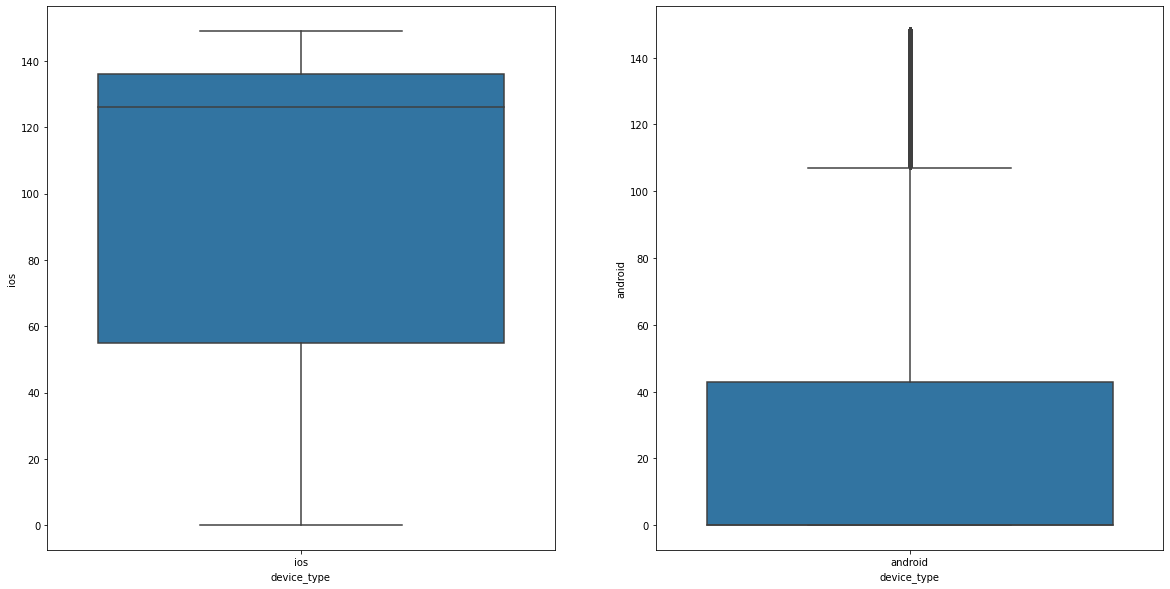

In [364]:
selection = set(data['device_type'])
fig, axes = plt.subplots(1, len(selection), figsize = (20, 10))
for i, col in enumerate(selection):
    mask = data['device_type'] == col
    ax = sns.boxplot(x="device_type", y="retention", data=data[mask], ax=axes.flatten()[i])
    ax.set_ylabel(col)
plt.show()

## Check whether there is an error in date updates

In [365]:
print(f"""Checking for negative retention days: \
 {len(data.loc[(data['last_touch'] - data['install_time']) < pd.Timedelta(0, 'days'), :])} days """)

Checking for negative retention days:  0 days 


## DATA PREPROCESSING
- ` Let's drop unnessesary columns`
- `Aggregate features from users actions - Dim_user_selections `
` 
- `And check the balance in data regarding the target retention`
- `Apply sampling techniques if needed`

In [372]:
def plot_corr(data):
    data_corr = data.corr('kendall')
    mask = np.zeros_like(data_corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    data_corr[mask] = np.nan
    return (data_corr.style.\
            background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1).\
            highlight_null(null_color='#f1f1f1'))

In [373]:
def check_types(data):
    cols = ['wizard_teams', 'wizard_leagues', 'lang_id', 'country_id', \
    'media_source' , 'device_type', 'os_version', 'campaign_name', 'is_finished_wizard', \
    'device_model', 'is_google_connect', 'is_facebook_connect', 'retention', \
            'user_country', 'user_language', 'favorite', 'region_name', 'entity_id',\
            'app_version', 'churn']
    for i in cols:
        if data[i].dtype == 'object':
            data[i] = data[i].astype('category').cat.codes
    return data[cols]

In [374]:
data_corr = check_types(data)
plot_corr(data_corr)

/Users/m.shark/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4812: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


,wizard_teams,wizard_leagues,lang_id,country_id,media_source,device_type,os_version,campaign_name,is_finished_wizard,device_model,is_google_connect,is_facebook_connect,retention,user_country,user_language,favorite,region_name,entity_id,app_version,churn
wizard_teams,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
wizard_leagues,0.689243,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
lang_id,-0.111684,-0.068677,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
country_id,0.119185,0.107373,0.254138,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
media_source,-0.074061,-0.070257,0.278940,0.000910,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
device_type,0.074802,0.057826,0.372297,0.341989,-0.110470,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
os_version,0.010639,0.000665,0.193935,0.181210,-0.052221,0.463473,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
campaign_name,-0.157378,-0.147764,0.296413,-0.066382,0.760060,-0.182716,-0.089962,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
is_finished_wizard,0.070543,0.068616,0.673381,0.479147,0.195006,0.607104,0.313054,0.152284,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
device_model,-0.057279,-0.051317,-0.359636,-0.312423,-0.092018,-0.312162,-0.212617,-0.029414,-0.546800,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


### For correlation computing I use non-parametric Kendall correlation that suits for continues and ordinary data and suits for finding non-linear correlations




- 'So "is_finished_wizard" is higly correlated with lang_id
- 'Target churn is correlated with lang_id, device_type and is_finished_wizard, device_model'
- 'Device_type and device_model have low correlation coff, but it's evident that Device_type is the generalizing upon device_model'
- 'campaign_name' is higly correlated with 'media_source'

As we have a lot of correlations and can't be sure in it, I propose not to use as a baseline linear model


## We have 63 : 37 balance in target class, we have more active users then who decided to leave

Almost all additional data from action table we have, provides data only if the user was active

In [384]:
round(data.query('churn == 0').shape[0] / data.shape[0], 2)

0.63

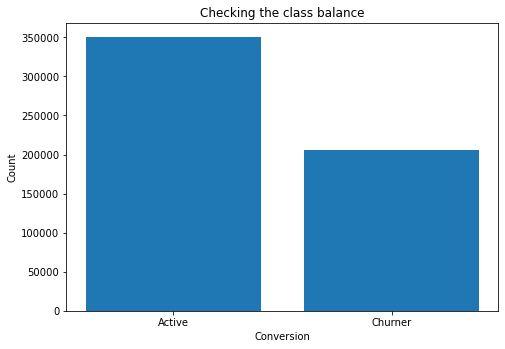

In [375]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(['Active', 'Churner'],[data.query('churn == 0').shape[0], data.query('churn == 1').shape[0]])
plt.title('Checking the class balance')
plt.xlabel("Conversion")
plt.ylabel("Count")
plt.show()

### Baseline model

- ### Let's train a Benchmark model on our data.  I propose to use Random Forest model. It can handle the data set containing categorical and continuous variables. After training we can compute  how much each feature contributes to decreasing the impurity. 


- ### Let's add one non-standard thing in preparing the data. I propose to add  a random column to the dataset. It has no predictive power over the dependent variable, so it should not be an important feature in methods that will be used for finding the most promising features.

In [385]:
data_corr['random'] = np.random.random(size = len(data_corr)).astype('float')


/var/folders/bm/fy2d0g0j55g433k7nbx5c6dc0000gn/T/ipykernel_20049/1836785790.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_corr['random'] = np.random.random(size = len(data_corr)).astype('float')


In [386]:
def baseline_with_metrics(df, n):
    SEED = 42
    mean_auc = 0.
    oob_score = 0.
    test_accuracy = 0.
    for i in range(n):
        clf = RandomForestClassifier(n_estimators = 100,
                                     n_jobs = -1,
                                     oob_score = True,
                                     bootstrap = True,
                                     class_weight = 'balanced', random_state = 42)

        X, y = df.drop(columns = ['churn', 'retention']), df['churn']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = i*SEED)
        clf.fit(X_train, y_train)

        preds = clf.predict(X_test)
        print(f'{i} split training')
        print(f'precision on test {metrics.precision_score(y_test, preds)}')
        print(f'recall on test {metrics.recall_score(y_test, preds)}')
        print('-------------')
        
        mean_auc += metrics.roc_auc_score(y_test, preds)
        oob_score += clf.oob_score_
        test_accuracy += clf.score(X_test, y_test)


        importances = clf.feature_importances_
        std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

        forest_importances = pd.Series(importances, index=X.columns)
        forest_importances = forest_importances.sort_values(ascending = False)
        fig, ax = plt.subplots(figsize = (10, 4))
        forest_importances.plot.bar(yerr=std, ax=ax)
        ax.set_title("Feature importances")
        ax.set_ylabel("Mean decrease in impurity")
        fig.tight_layout()


    print(f"Mean test roc_auc {round(mean_auc/n, 3)}")
    print(f"Mean out-of-bag accuracy {round(oob_score/n, 3)}")
    print(f"Mean accuracy in test {round(test_accuracy/n, 3)}")
    return forest_importances
    

0 split training
precision on test 0.9873335576599529
recall on test 0.9954925481643039
-------------
1 split training
precision on test 0.9870467568738864
recall on test 0.994517490660327
-------------
2 split training
precision on test 0.9871078642028362
recall on test 0.9948508180943214
-------------
Mean test roc_auc 0.994
Mean out-of-bag accuracy 0.993
Mean accuracy in test 0.993


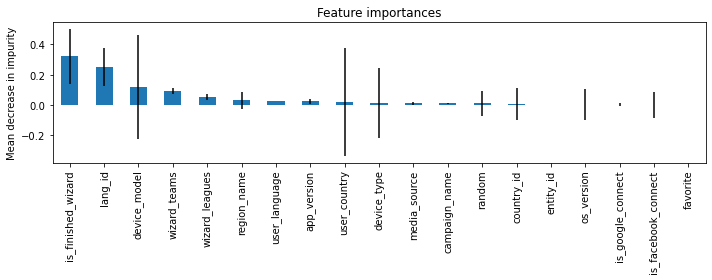

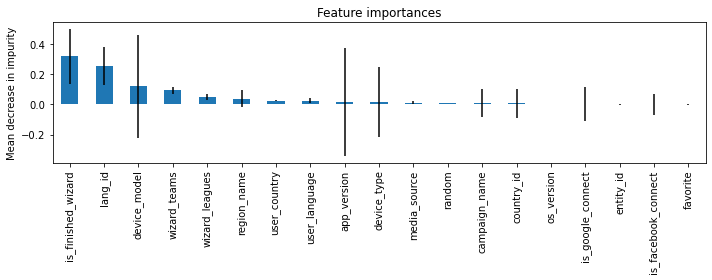

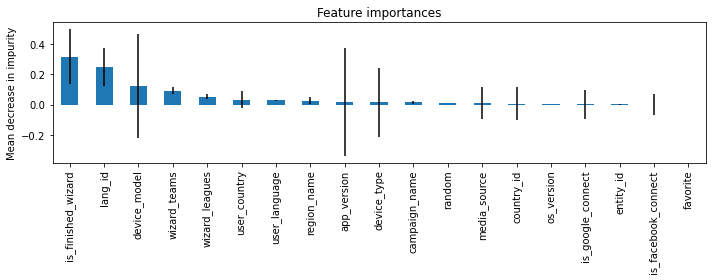

In [387]:
forest_importances = baseline_with_metrics(data_corr.fillna(0), 3)

###  `The activity table mostly contains the data about users who are active with good retention`

In [390]:
# The activity table 
data_corr[data_corr[['user_country', 'user_language', \
                    'favorite', 'region_name', 'entity_id', 'app_version']].\
                      notnull().all(axis = 1)]['churn'].value_counts()

0    227105
1      2752
Name: churn, dtype: int64

In [391]:
data_corr[data_corr.notnull().all(axis = 1)]['churn'].value_counts()

0    219329
Name: churn, dtype: int64

### Let's do the prediction with only features that are available for all types of users (active and unactive) 

0 split training
precision on test 0.9870423347837585
recall on test 0.9949836423118866
-------------
1 split training
precision on test 0.9865931738314158
recall on test 0.9943476784241424
-------------
2 split training
precision on test 0.9866141732283464
recall on test 0.9949230028873918
-------------
Mean test roc_auc 0.993
Mean out-of-bag accuracy 0.993
Mean accuracy in test 0.993


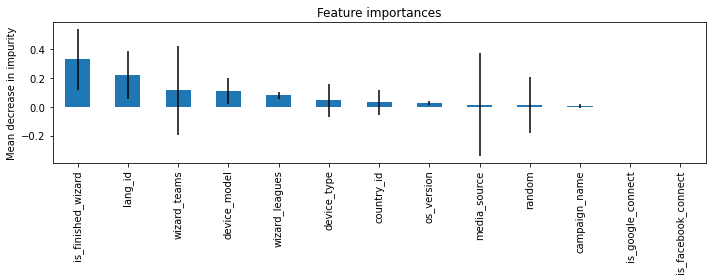

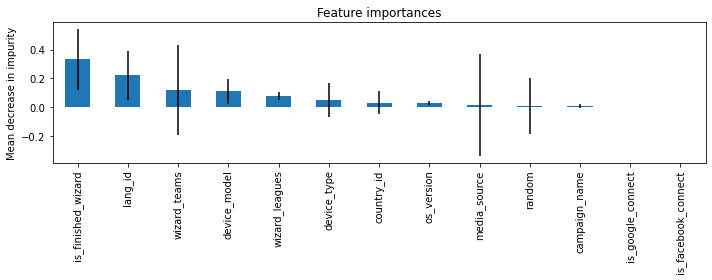

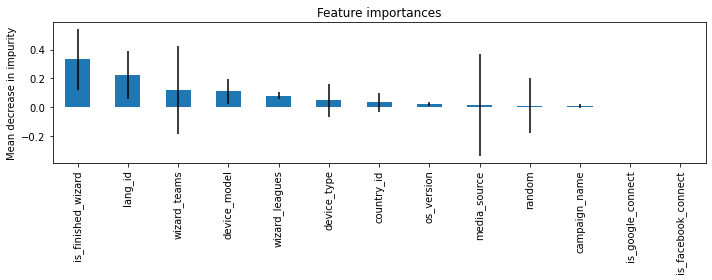

In [392]:
cols = ['user_country', 'user_language', \
                    'favorite', 'region_name', 'entity_id', 'app_version']
df = data_corr.loc[:, ~data_corr.columns.isin(cols)].fillna(0).copy()
forest_importances = baseline_with_metrics(df, 3)

## And also I will propose to exclude all features with importance less then random feature has

In [393]:
val = forest_importances[forest_importances.index == 'random'].values[0]
new_features = forest_importances[forest_importances.values > val].index

0 split training
precision on test 0.9865778246488663
recall on test 0.9975039379619532
-------------
1 split training
precision on test 0.9866801065591475
recall on test 0.997331522002814
-------------
2 split training
precision on test 0.9863127826707927
recall on test 0.9969923002887392
-------------
Mean test roc_auc 0.995
Mean out-of-bag accuracy 0.994
Mean accuracy in test 0.994


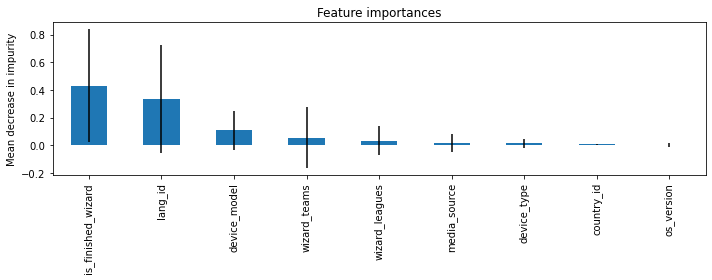

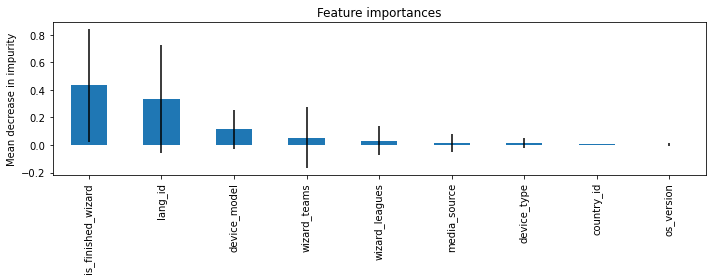

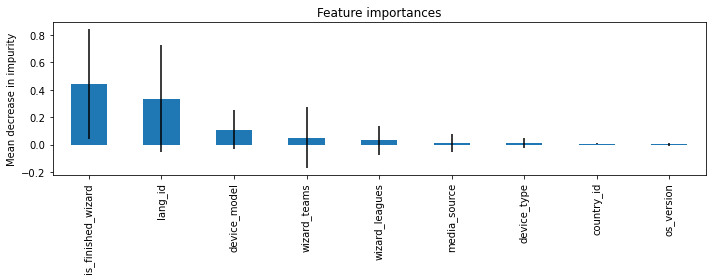

In [394]:
df = data_corr.loc[:, new_features.tolist() + ['churn', 'retention']].fillna(0).copy()
new_forest_importances = baseline_with_metrics(df, 3)

- `The main assumptions we should consider that our baseling is RF clf, so we should assume that it's a biased approach and it has a tendency to inflate the importance of continuous features or high-cardinality categorical variables`
- `Also we have a little unbalanced dataset and some sampling techniques could be applied but we have cery good metrics on test set, so I decided not to apply them. In case of using it, we should aim to use generalised. Need to do undersampling step multiple times and obtain many different undersampled datasets to train our model on to avoid bias `